In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import spearmanr
import re
pd.set_option('display.max_columns', None)
%pylab inline 
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# INTRODUCING OUR DATASET 


Our input consists of a survey reponse, along with some additional details about the students and their search data. 
The survey is as follows: 
1. - present background of student (applying, currently enrolled, etc) 
2. - 3 preferences of higher education (institute type, institution, level and career) 
3. - sureity of options listed in #2
4. - annual cost estimates for studying at these institutions 
5. - monthly salary expectations (own and typical)
6. - math and language scores (Expected in application)

In the next step, we load our data into a pandas dataframe and relabel some of the columns (out of convenience). 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
survey = pd.read_csv('edu_chile_survey_output.csv', header = 0, low_memory = False)
survey.rename(columns={'rut_orig':'ID', 'q1':'q1_postsec', 'q2_tipo_1_orig':'q2_institute_type_1', 
                       'q2_tipo_2_orig':'q2_institute_type_2', 'q2_tipo_3_orig':'q2_institute_type_3', 
                       'q2_nivel_1':'q2_level_1', 'q2_nivel_2':'q2_level_2', 'q2_nivel_3':'q2_level_3', 
                       'q2_carerra_1':'q2_career_1', 'q2_carerra_2':'q2_career_2', 'q2_carerra_3':'q2_career_3', 
                       'q4_nose_1_orig':'q4_IDK_1', 'q4_nose_2_orig':'q4_IDK_2', 'q4_nose_3_orig':'q4_IDK_3', 
                       'q4_cost_1_orig':'q4_TuitionEstimate_1', 'q4_cost_2_orig':'q4_TuitionEstimate_2', 
                       'q4_cost_3_orig':'q4_TuitionEstimate_3',  'q5_mi_ing_1_orig':'q5_ownwages_1', 
                       'q5_mi_ing_2_orig':'q5_ownwages_2', 'q5_mi_ing_3_orig':'q5_ownwages_3', 
                       'q5_tip_ing_1_orig':'q5_typwages_1', 'q5_tip_ing_2_orig':'q5_typwages_2', 
                       'q5_tip_ing_3_orig':'q5_typwages_3', 'q6_math_orig':'q6_math', 
                       'q5_tip_nose_1_orig': 'q5_IDK_own_1', 'q5_tip_nose_2_orig': 'q5_IDK_own_2', 
                       'q5_tip_nose_3_orig': 'q5_IDK_own_3', 'q5_mi_nose_1_orig': 'q5_IDK_typ_1',
                       'q5_mi_nose_2_orig': 'q5_IDK_typ_2', 'q5_mi_nose_3_orig': 'q5_IDK_typ_3',
                       'q6_lang_orig': 'q6_lang','PSU_leng_2013': 'lang_score', 'PSU_mate_2013': 'math_score', 
                       'PSU_2013':'comp_score','SIMCEMath10':'math_10', 'SIMCELang10':'lang_10', 
                       'mom_educ_simce':'educ_mom', 'dad_educ_simce':'educ_dad'
                      }, inplace=True)


# DETERMINING THOSE WHO SEARCHED THE DATABASE 

In this next step, we create a new variable to indicate whether the student searched the database or not. This is simply done by creating a new column 'survey_participant' and labeling it as 0 (did not participate) or 1 (participated). We determine participation by seeing if there were inputs in the first search done by the user or not. 

In [4]:
search_report = (survey[['search1_psu_math','search1_psu_lang','search1_area',
                         'search1_nivel','search1_carrer']]).dropna() # columns of first search 

rows = list(search_report.index) # extract indexes of search_report because some rows were omitted 
r = survey.shape[0]
results = [0] * r  # list with r zeros 

for row in rows: 
    results[row] = 1 # if the student participated, we change value to 1 

survey['survey_participant'] = results

# DATA CLEANING 

In this step, we set out to clean our data, since it contains several NaN values. We have two kinds of data - numerical and categorical. For our numerical data, we remove the rows containing NaN values and then clean it by removing characters that would not allow them to resemble float values (for example, the dollar sign). An entry such as '$4.000.000' is corrected to '4000000'. 


In [5]:
#removing any rows that have all NaN valus 
survey = survey.dropna(axis = 0, how = 'all')

We separate our numerical and categorical columns to make them easier to work with later in the program. 

In [6]:
numerical_inputs = ['q4_TuitionEstimate_1', 'q4_TuitionEstimate_2', 'q4_TuitionEstimate_3', 
                    'q5_ownwages_1', 'q5_ownwages_2', 'q5_ownwages_3',  'q5_typwages_1', 
                    'q5_typwages_2', 'q5_typwages_3', 'q6_math', 'q6_lang','lang_score', 
                    'math_score', 'comp_score', 'math_10', 'lang_10']

categorical_inputs = ['q1_postsec','q2_institute_type_1', 'q2_institute_type_2', 'q2_institute_type_3',
                      'q2_level_1', 'q2_level_2', 'q2_level_3', 'q2_career_1', 'q2_career_2', 'q2_career_3',
                      'q2_inst_1', 'q2_inst_2', 'q2_inst_3', 'q3', 'q4_IDK_1', 'q4_IDK_2', 'q4_IDK_3', 
                      'q5_IDK_own_1', 'q5_IDK_own_2', 'q5_IDK_own_3', 'q5_IDK_typ_1', 'q5_IDK_typ_2', 'q5_IDK_typ_3', 
                      'educ_mom', 'educ_dad', 'schl_type', 'rbdRating']

numerical_outputs = [ 'search1_psu_math', 'search1_psu_lang', 'search2_psu_math', 'search2_psu_lang', 
                      'search3_psu_math', 'search3_psu_lang', 'search4_psu_math', 'search4_psu_lang', 
                      'search5_psu_math', 'search5_psu_lang', 'search6_psu_math', 'search6_psu_lang', 
                      'search7_psu_math', 'search7_psu_lang', 'search8_psu_math', 'search8_psu_lang', 
                      'search9_psu_math', 'search9_psu_lang', 'search10_psu_math', 'search10_psu_lang']

categorical_outputs = ['search1_nivel', 'search1_carrer', 'search2_nivel', 'search2_carrer',
                       'search3_nivel', 'search3_carrer', 'search4_nivel', 'search4_carrer',
                       'search5_nivel', 'search5_carrer', 'search6_nivel', 'search6_carrer',
                       'search7_nivel', 'search7_carrer', 'search8_nivel', 'search8_carrer',
                       'search9_nivel', 'search9_carrer', 'search10_nivel', 'search10_carrer']

Cleaning of numerical data below, through the use of regular expressions. 

In [7]:
def clean_numerical_inputs(sub):
    cleaned_data = pd.DataFrame(sub)
    for column in sub: 
        if column in ['math_10', 'lang_10']: 
            continue
        l = []
        x = sub[column]
        for value in x:
            q = re.findall(r'\d+',str(value)) # we extract just the numbers using regular expression 
            if q ==[]: 
                l.extend([None])
                continue
            l.append(int(q[0]))
        cleaned_data[column] = l
    return cleaned_data

# we call the clean inputs function to 
survey[numerical_inputs]  = clean_numerical_inputs(survey[numerical_inputs])
survey[numerical_outputs]  = clean_numerical_inputs(survey[numerical_outputs])

Now, we focus on cleaning our categorical data. We noticed that about 23% of students dont have entries for 
their first choice of institute, level and career, 30% for their second, and 34% for their third, we make a 
transformation on our data. We convert those values to unknown, which in itself represents a (very valid) category 
of students who are not sure of their plans.

In [8]:
'''This block shows the fraction of NaN values in our categorical data. ''' 

print 'Institute 1: ', "{0:.2f}".format(sum((survey['q2_inst_1']).isnull())/
    float(len(survey['q2_career_1']))*100),'% and Level 1: ', "{0:.2f}".format(sum((survey['q2_level_1']).isnull())/
    float(len(survey['q2_career_1']))*100),'% and Career 1: ', "{0:.2f}".format(sum((survey['q2_career_1']).isnull())/
    float(len(survey['q2_career_1']))*100),'%'
print 'Institute 2: ', "{0:.2f}".format(sum((survey['q2_inst_2']).isnull())/
    float(len(survey['q2_career_1']))*100),'% and Level 2: ', "{0:.2f}".format(sum((survey['q2_level_2']).isnull())/
    float(len(survey['q2_career_1']))*100),'% and Career 2: ', "{0:.2f}".format(sum((survey['q2_career_2']).isnull())/
    float(len(survey['q2_career_1']))*100),'%'
print 'Institute 3: ', "{0:.2f}".format(sum((survey['q2_inst_3']).isnull())/
    float(len(survey['q2_career_1']))*100),'% and Level 3: ', "{0:.2f}".format(sum((survey['q2_level_3']).isnull())/
    float(len(survey['q2_career_1']))*100),'% and Career 3: ', "{0:.2f}".format(sum((survey['q2_career_3']).isnull())/
    float(len(survey['q2_career_1']))*100),'%'

Institute 1:  23.97 % and Level 1:  23.96 % and Career 1:  23.98 %
Institute 2:  30.71 % and Level 2:  30.71 % and Career 2:  30.71 %
Institute 3:  34.81 % and Level 3:  34.81 % and Career 3:  34.81 %


In [9]:
'''We now transform the missing categorical inputs to 'unknown', which becomes a category of its own. We restict our
transformation to the responses made to question 2 because the reasoning doesn't extend to questions 1 and 3.'''

q1q2q3_responses = ['q1_postsec', 'q2_institute_type_1', 'q2_institute_type_2', 'q2_institute_type_3',
                        'q2_level_1', 'q2_level_2', 'q2_level_3', 'q2_career_1', 'q2_career_2', 
                        'q2_career_3', 'q2_inst_1', 'q2_inst_2', 'q2_inst_3', 'q3']

for column in survey[q1q2q3_responses]: 
    rows = survey[column].isnull()
    row = [i for i, x in enumerate(rows) if x]
    survey[column].loc[rows] = 'unknown'

# DIMENSIONATILY REDUCTION 

Now that our data is clean, we consider dimensionality reduction. Instead of using the large 
number of features provided, we check to see if they can be condensed. This is done by observing the correlations between two different variables (there are some more sophisticated methods involved, but I decided to keep it simple for now). On running the code below, we noticed that there were correlations between the institution and type of institute, as well as level and career, which were good enough to mention but not really consider in our analysis since they didn't help much in the initial dimension reduction process. 

Note that the print line has been commented to condense the size of this notebook. The details of the correlations can be viewed by simply removing the '#' in the last line. 

In [10]:
observed_categories = []
for x in survey[categorical_inputs]: 
    observed_categories.extend([x]) # avoid calculating both corr(x,y) and corr(y,x)
    col_1 = survey[x]
    for y in survey[categorical_inputs]: 
        if x == y or y in observed_categories: 
            continue
        col_2 = survey[y]
        #print "The correlation between", x , 'and', y , 'is', spearmanr(col_1,col_2)

We also considered doing a dimensionality reduction on our numerical data, but the number of dimensions were not significant enough to act on it (the test scores would reduce to 3 columns instead of 7 to capture over 90% of the variation, so I decided to let it be for the time being). The wages data was too distorted for the result to be of any import, as we shall discuss later.

In [11]:
drop_missing_numbers = survey[numerical_inputs].dropna()
final_rows = drop_missing_numbers.index

# TRAINING AN INITIAL MODEL 

Now that we have cleaned our data, its time to do a initial analysis by running it in a model. Since the problem at hand is a typical classification problem, we consider some of the models that help us solve it. After we clean our data, models are not too hard or lengthly to implement, so we consider some different models here, including Random Forests, Logistic Regression, Adaboost classifiers, and Support Vector Machines. They cover both linear and non-linearly distributed data, which provides us with some variety in our analysis. The final_rows variable below is used to drop the rows that have NaN numerical inputs (we discussed this in the previous section). 

In [12]:
#we extract the relevant rows into final_survey, and rename the indexes in our dataframe
final_survey = survey.ix[final_rows,]
default_rows = range(0,len(final_survey))
final_survey.index = default_rows 

features = categorical_inputs + numerical_inputs

'''We construct our final dataframe report, which will be used in our further analysis. 
We also add the participant column to it. '''

report = final_survey[features]
report['survey_participant'] = final_survey['survey_participant'] 

# ENCODING OUR DATA 

As we have seen earlier, there are a large number of categorical inputs that we have, which python's classifiers do not like. To resolve this issue, we encode those inputs using the scikit-learn's LabelEncoder() function, which converts them to values that a classification model will accept. We also use the StandardScaler() function to scale some of our numerical inputs for our model to run. 

In [13]:
le = LabelEncoder() # encodes categorical inputs 
nm = StandardScaler() # normalizes numerical inputs 
variables = pd.DataFrame()

for column in features: 
    #print column
    x = report[column]
    if column == 'survey_participant': 
        continue
    if column not in numerical_inputs: 
        le.fit(x)
        var = pd.DataFrame(le.transform(x))
        variables = pd.concat([variables,var], axis=1)
    else:    
        nm.fit(x)
        var = pd.DataFrame(nm.transform(x))
        variables = pd.concat([variables,var], axis=1)

# RUNNING A MODEL 

Finally, after encoding our data, we run it through the different models that we chose. 

In [18]:
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

methods = {"Gradient Boosting": GradientBoostingClassifier(), 
           "Logistic Regression":LogisticRegression(), 
           "Support Vector Machines": svm.SVC(), 
           "AdaBoost Classifier": AdaBoostClassifier(), 
           "Random Forests":RandomForestClassifier(n_estimators = 1000, n_jobs = 2), 
           "Ridge Classifier": RidgeClassifierCV()}

initial_errors = {}
kf = KFold(report.shape[0], n_folds = 5)

for train_index, test_index in kf: 
    # we split our data into training and testing sets 
    X_train, X_test = variables.ix[list(train_index),], variables.ix[list(test_index),]
    y_train = report['survey_participant'].ix[list(train_index),]
    y_test = report['survey_participant'].ix[list(test_index),]
    
    # we run a loop over all the models that we are considering 
    for model_name in methods: 
        md = methods[model_name]
        md.fit(X_train, y_train) # fit the model 
        y_hat = list(md.predict(X_test)) # predict output for test data 
        error = sum((y_hat-y_test)**2)/float(len(y_test))
        if model_name in initial_errors: 
            initial_errors[model_name].append(error)
        else:     
            initial_errors[model_name] = [error]
        print model_name, "{0:.3f}".format(sum((y_hat-y_test)**2)/float(len(y_test))), '%'


Ridge Classifier 0.439 %
Random Forests 0.443 %
Gradient Boosting 0.434 %
Logistic Regression 0.439 %
Support Vector Machines 0.468 %
AdaBoost Classifier 0.433 %
Ridge Classifier 0.447 %
Random Forests 0.444 %
Gradient Boosting 0.447 %
Logistic Regression 0.445 %
Support Vector Machines 0.457 %
AdaBoost Classifier 0.447 %
Ridge Classifier 0.449 %
Random Forests 0.448 %
Gradient Boosting 0.444 %
Logistic Regression 0.450 %
Support Vector Machines 0.481 %
AdaBoost Classifier 0.441 %
Ridge Classifier 0.430 %
Random Forests 0.435 %
Gradient Boosting 0.443 %
Logistic Regression 0.434 %
Support Vector Machines 0.467 %
AdaBoost Classifier 0.446 %
Ridge Classifier 0.439 %
Random Forests 0.466 %
Gradient Boosting 0.455 %
Logistic Regression 0.438 %
Support Vector Machines 0.475 %
AdaBoost Classifier 0.449 %


# INITIAL CONCLUSIONS 

On running our models, we notice that the error rates are pretty high. In fact, it is close to maximum error since in a classifier, if we had 100% error, that could be fixed by simply inverting the classifier. 50% error is worst case. It seems like these state-of-the-art models didn't do a good enough job on the data set that we have, but why may that be? We investigate this case in our next section. 

# VARIANCE ANALYSIS 

Since our models didn't give us desired results, we explore our input features to see if there is some insight that they could provide. We divide our data into the groups that say yes, and those that say no. A high variation between these two groups will be a good thing, as those variations will help us identify what differentiates the two groups. For example, if test scores are significantly higher for those who use the database than those who don't (not the case here), then test scores would be a good category to include in our model. We look at our different inputs in the section below (post secondary details, institute, career and level preferences, wages and cost estimates as well as test scores.

In [14]:
# the two groups, and their lengths 
yes_group = final_survey.ix[final_survey['survey_participant'] == 1,]
no_group = final_survey.ix[final_survey['survey_participant'] == 0,]

yes_rows =  yes_group.shape[0]
no_rows = no_group.shape[0]

In [15]:
'''We define a function that tells us the ratio between the counts of different categories in each feature. Simply 
put, if 9 of 10 students in the yes group list university as the first institute type choice, and 5 of 10 in the no 
do it, the function changes these values to 0.9 and 0.5 respectively. The Counter() determines the nominal counts of 
the different categories. 
'''

from collections import Counter
def normalize_ratios(a, b): 
    for key in a: 
        if key not in b: 
            continue
        value1 = a[key]
        value2 = b[key]
        a[key] = round(value1/float(yes_rows),3)
        b[key] = round(value2/float(no_rows),3)
    return a, b 

for column in categorical_inputs: 
    yes = yes_group[column]
    no = no_group[column]    
    yes = dict(Counter(yes))
    no = dict(Counter(no))
    yes, no = normalize_ratios(yes, no)

A close analysis of the prior results obtained will reflect variations only in the choice of institute, career, level, and sureity of choice. These are the cause of the efficiency (although somewhat low) of our initial test in the previous section (as a simple check of features significance reveals). After doing our variation study on the categorical inputs, we move onto our numerical inputs.  

In [16]:
#computing means and standard deviations for yes and no groups 

yes_avg_scores = yes_group[numerical_inputs].mean(axis = 0)
no_avg_scores = no_group[numerical_inputs].mean(axis = 0)

yes_std_scores = yes_group[numerical_inputs].std(axis = 0)
no_std_scores = no_group[numerical_inputs].std(axis = 0)

Below, we list the averages of the numerical inputs, to notice that there is significant overlap between the two mean values and standard deviations between the two groups (this can be tested simply by carrying out a null hypothesis test). 

In [17]:
# printing the different numerical input means and their standard deviations 

for column in numerical_inputs:  
    if column == 'q4_TuitionEstimate_3': 
        continue
    yes_avg = yes_avg_scores[column]
    no_avg = no_avg_scores[column]
    yes_std = yes_std_scores[column]
    no_std = no_avg_scores[column]
    print "YES GROUP AVG:", column, "{0:.2f}".format(yes_avg), "YES GROUP SD:",  column, "{0:.2f}".format(yes_std)
    print "NO GROUP AVG:", column, "{0:.2f}".format(no_avg), "NO GROUP SD:", column, "{0:.2f}".format(no_std)

YES GROUP AVG: q4_TuitionEstimate_1 3222220.31 YES GROUP SD: q4_TuitionEstimate_1 66827492.79
NO GROUP AVG: q4_TuitionEstimate_1 2380810.00 NO GROUP SD: q4_TuitionEstimate_1 2380810.00
YES GROUP AVG: q4_TuitionEstimate_2 3101701.40 YES GROUP SD: q4_TuitionEstimate_2 75641856.24
NO GROUP AVG: q4_TuitionEstimate_2 2251238.06 NO GROUP SD: q4_TuitionEstimate_2 2251238.06
YES GROUP AVG: q5_ownwages_1 909222.05 YES GROUP SD: q5_ownwages_1 16555984.18
NO GROUP AVG: q5_ownwages_1 736014.48 NO GROUP SD: q5_ownwages_1 736014.48
YES GROUP AVG: q5_ownwages_2 801264.07 YES GROUP SD: q5_ownwages_2 14196164.86
NO GROUP AVG: q5_ownwages_2 538652.42 NO GROUP SD: q5_ownwages_2 538652.42
YES GROUP AVG: q5_ownwages_3 730584.84 YES GROUP SD: q5_ownwages_3 14193306.96
NO GROUP AVG: q5_ownwages_3 488181.70 NO GROUP SD: q5_ownwages_3 488181.70
YES GROUP AVG: q5_typwages_1 3561499.04 YES GROUP SD: q5_typwages_1 236581117.96
NO GROUP AVG: q5_typwages_1 552439.94 NO GROUP SD: q5_typwages_1 552439.94
YES GROUP AV

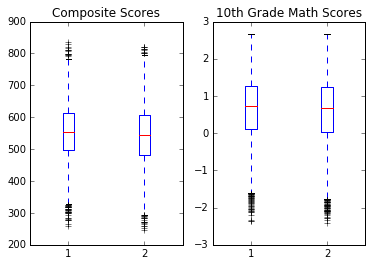

In [18]:
# We create boxplots to present the opinion that the numerical inputs are largely not helpful 

fig , ax = plt.subplots(1,2)
ax[0].boxplot([yes_group['comp_score'],no_group['comp_score']]); 
ax[0].set_title('Composite Scores');
ax[1].boxplot([yes_group['math_10'],no_group['math_10']]);
ax[1].set_title('10th Grade Math Scores');

And the story is pretty much the same for all the other numerical inputs. Similar means and/or very high variances exist that create an overlap between two data sets. As a consequence, these features pass the null hypothesis test and do not provide any support in our study. 

# IMPLEMENTING MODELS WITH FEWER FEATURES

Now that we have determined that a large fraction of our input variables are of not much use, we run the same models from earlier with fewer features.

In [19]:
# We encode our features in this block of code 

features = q1q2q3_responses

le = LabelEncoder() # encodes categorical inputs 
nm = StandardScaler() # normalizes numerical inputs 
variables = pd.DataFrame()

for column in features: 
    #print column
    x = report[column]
    if column in ['survey_participant', 'q1_postsec']: 
        continue
    if column not in numerical_inputs: 
        le.fit(x)
        var = pd.DataFrame(le.transform(x))
        variables = pd.concat([variables,var], axis=1)
    else:    
        nm.fit(x)
        var = pd.DataFrame(nm.transform(x))
        variables = pd.concat([variables,var], axis=1)

In [26]:
# We run our model in this block of code 

kf = KFold(report.shape[0], n_folds = 5)
final_errors = {}
for train_index, test_index in kf: 
    # we split our data into training and testing sets 
    X_train, X_test = variables.ix[list(train_index),], variables.ix[list(test_index),]
    y_train = report['survey_participant'].ix[list(train_index),]
    y_test = report['survey_participant'].ix[list(test_index),]
    
    # we run a loop over all the models that we are considering 
    for model_name in methods: 
        md = methods[model_name]
        md.fit(X_train, y_train) # fit the model 
        y_hat = list(md.predict(X_test)) # predict output for test data 
        error = sum((y_hat-y_test)**2)/float(len(y_test))
        if model_name in final_errors: 
            final_errors[model_name].append(error)
        else:     
            final_errors[model_name] = [error]
        print model_name, "{0:.3f}".format(sum((y_hat-y_test)**2)/float(len(y_test))), '%'


Ridge Classifier 0.450 %
Random Forests 0.479 %
Gradient Boosting 0.462 %
Logistic Regression 0.449 %
Support Vector Machines 0.459 %
AdaBoost Classifier 0.467 %
Ridge Classifier 0.465 %
Random Forests 0.470 %
Gradient Boosting 0.454 %
Logistic Regression 0.466 %
Support Vector Machines 0.460 %
AdaBoost Classifier 0.462 %
Ridge Classifier 0.470 %
Random Forests 0.484 %
Gradient Boosting 0.468 %
Logistic Regression 0.470 %
Support Vector Machines 0.477 %
AdaBoost Classifier 0.470 %
Ridge Classifier 0.454 %
Random Forests 0.476 %
Gradient Boosting 0.454 %
Logistic Regression 0.453 %
Support Vector Machines 0.459 %
AdaBoost Classifier 0.457 %
Ridge Classifier 0.476 %
Random Forests 0.483 %
Gradient Boosting 0.459 %
Logistic Regression 0.476 %
Support Vector Machines 0.475 %
AdaBoost Classifier 0.468 %


# SUCCESSFULLY REDUCING COMPUTATIONAL COSTS 

As we note above, the error is largely unchanged, regardless of whether we use over 30 features or around 10 features. This is helpful to know as the fewer the features we use, the lower is our computational cost without much change in accuracy (more relevant in a general sense than towards this case). Below we see a comparison of mean errors produced using this data, and then we can now make some concluding statements about this data.

In [27]:
for key in methods: 
    a = mean(initial_errors[key])
    b = mean(final_errors[key])
    print key, ": More Features Error:", "{0:.3f}".format(a), "% Fewer Features Error:", "{0:.3f}".format(b), '%'

Ridge Classifier : More Features Error: 0.441 % Fewer Features Error: 0.463 %
Random Forests : More Features Error: 0.447 % Fewer Features Error: 0.478 %
Gradient Boosting : More Features Error: 0.444 % Fewer Features Error: 0.460 %
Logistic Regression : More Features Error: 0.441 % Fewer Features Error: 0.463 %
Support Vector Machines : More Features Error: 0.470 % Fewer Features Error: 0.466 %
AdaBoost Classifier : More Features Error: 0.443 % Fewer Features Error: 0.465 %


# SOME CONCLUDING REMARKS 

As we notice here, the variable inputs that we have don't neccessarily help in determining which students would use our database and which students would chose not to. It almost seems like there is low predictability in who might use the database and who wouldn't. (There may be a trick or two more in the bag to resolve this issue, and I'll most certainly explore it once I've stayed away from the dataset for a reasonable amount of time.) A policy maker can approach this problem in two different ways: 

1. Target giving access to the database to all students instead of targeting ones that are likely to use it/figuring out ways to reach the students who won't.

2. Another possible option is to expand the scope of the survey. This generates more features that could be more useful in predicting students more likely to use the database. 